# Import

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
import time
import numpy as np
import sys, os
import json

import qcodes as qc
from qcodes.dataset.plotting import plot_by_id

from scipy.optimize import curve_fit

import xarray
from tqdm import tqdm

In [4]:
cooldown_folder = r"/notebooks" 
db_path = os.path.join(cooldown_folder, "GroupD_database.db")

qc.config.core.db_location = db_path

print(f"Main database: {qc.config.core.db_location}")

Main database: /notebooks/GroupD_database.db


# Resonator spectroscopy

Measured parameters: dict_keys(['presto_in_ch1_amplitude', 'presto_in_ch1_phase', 'presto_out_ch1_IF_freq'])
Independent parameters: ('presto_out_ch1_Probe_freq', 'presto_out_ch1_scale')
True
Resonance Frequency (fr) = 7.336647 GHz
Resonator Linewidth (κ) = 0.55709 MHz
13169.525674191258


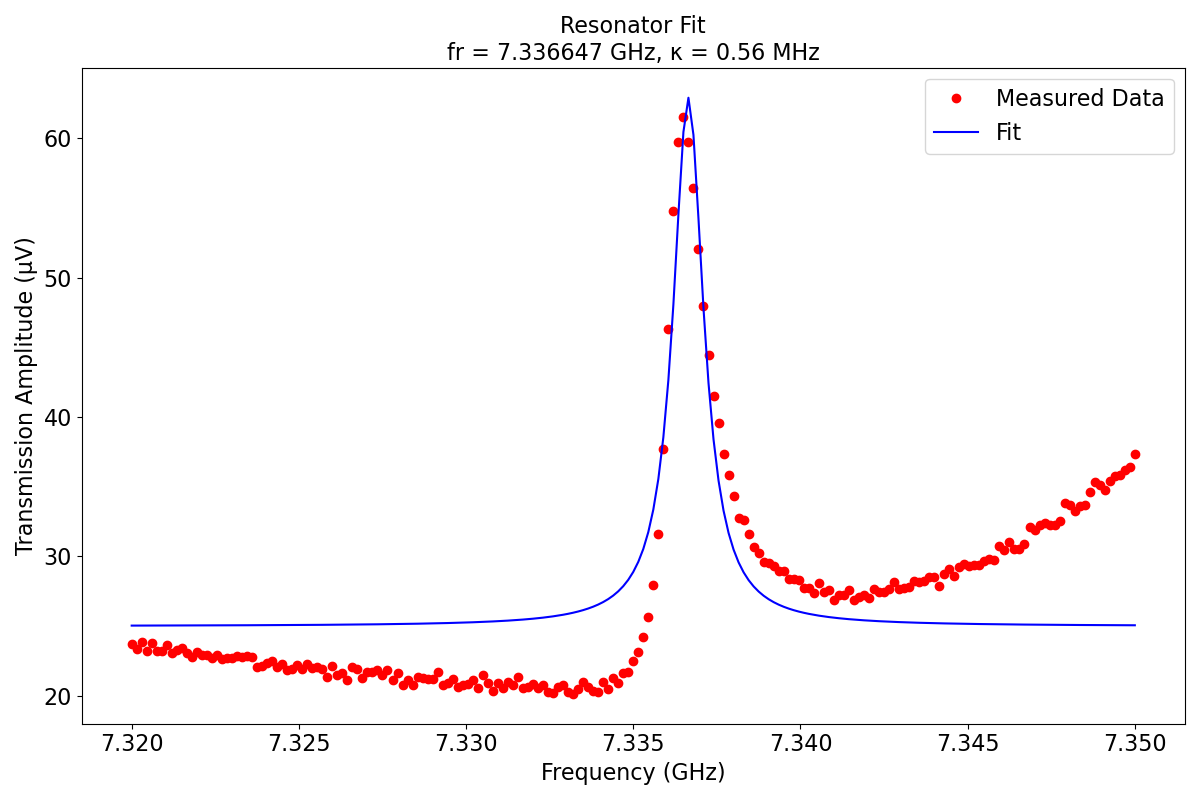

In [6]:
run_id = 2
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()
print(f"Measured parameters: {data.keys()}") # keys
data_amplitude = data["presto_in_ch1_amplitude"]  # we care about amplitude
print(f"Independent parameters: {data_amplitude.dims}")  # dimensions of amplitude (0=freq, 1=scale)
measured_values = data_amplitude.data 
indep_param_1 = data_amplitude[data_amplitude.dims[0]].data  # we want 0=probe_freq

f = indep_param_1
y = measured_values
y_mean = np.mean(y, axis=1)
print(y_mean.shape == f.shape)  

def lorentzian_with_kappa(f, fr, kappa, A, C):
    return C + (A * kappa**2) / ((f - fr)**2 + kappa**2)

def fit_lorentzian_with_kappa(f, y, guess=[7.3364e9, 5e6, 1e-5, 1e-5]): 
    popt, pcov = curve_fit(lorentzian_with_kappa, f, y_mean, p0=guess)
    return popt, pcov

initial_guess = [7.3364e9, 0.56e6, np.max(y) - np.min(y), np.min(y)]

popt, pcov = fit_lorentzian_with_kappa(f, y, guess=initial_guess)

def plot_resonator_fit_with_kappa(f, y, popt, ax=None):
    f_in_ghz = f / 1e9
    y_fit = lorentzian_with_kappa(f, *popt)  
    
    y_mean_microvolts = y_mean * 1e6
    y_fit_microvolts = y_fit * 1e6

    ax.plot(f_in_ghz, y_mean_microvolts, 'ro', label='Measured Data')  
    ax.plot(f_in_ghz, y_fit_microvolts, 'b-', label='Fit')  

    
    ax.set_xlabel('Frequency (GHz)', fontsize=16)
    ax.set_ylabel('Transmission Amplitude (\u03BCV)', fontsize=16)  
    ax.set_title(f'Resonator Fit\nfr = {popt[0]/1e9:.6f} GHz, κ = {popt[1]/1e6:.2f} MHz', fontsize=16)
    ax.legend(fontsize=16)

    
    ax.tick_params(axis='both', labelsize=16)


fig, ax = plt.subplots(figsize=(12, 8))  # Single plot
plot_resonator_fit_with_kappa(f, y, popt, ax=ax)
plt.tight_layout()
plt.savefig('resonator_fit_with_kappa.png')


fr, kappa, A, C = popt


print(f"Resonance Frequency (fr) = {fr/1e9:.6f} GHz")
print(f"Resonator Linewidth (κ) = {kappa/1e6:.5f} MHz")
print(fr/kappa)

# Qubit spectroscopy

In [5]:
run_id = 3
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()
print(f"Measured parameters: {data.keys()}") #keys
data_amplitude = data["presto_in_ch1_amplitude"] #we care about amplitude
print(f"Independent parameters: {data_amplitude.dims}") #dimns of amplitude and what they are each,it was 2 types i.e. 0=freq,1=scale
measured_values = data_amplitude.data 
indep_param_1 = data_amplitude[data_amplitude.dims[0]].data 

f = indep_param_1
y = measured_values
print(f.shape == y.shape)

Measured parameters: dict_keys(['presto_in_ch1_amplitude', 'presto_in_ch1_phase', 'presto_out_ch6_IF_freq'])
Independent parameters: ('presto_out_ch6_Probe_freq',)
True


In [6]:
def lorentzian(f, fq, Q, A, y0):
    return y0 + A / (1 + 4 * Q**2 * ((f - fq) / fq)**2)

initial_guess = [5.59e9, 500, np.max(y) - np.min(y), np.min(y)] #from measurements fr should be close to 5.592,from fit we get 5.5924

def fit_lorentzian(f, y, guess=initial_guess):
    popt, pcov = curve_fit(lorentzian, f, y, p0=guess)
    return popt, pcov

In [7]:
popt, pcov = fit_lorentzian(f, y)

fq, Q, A, y0 = popt

Qubit Frequency (fq) = 5.592462 GHz
Quality Factor (Q) = 6328
883781.8824610787


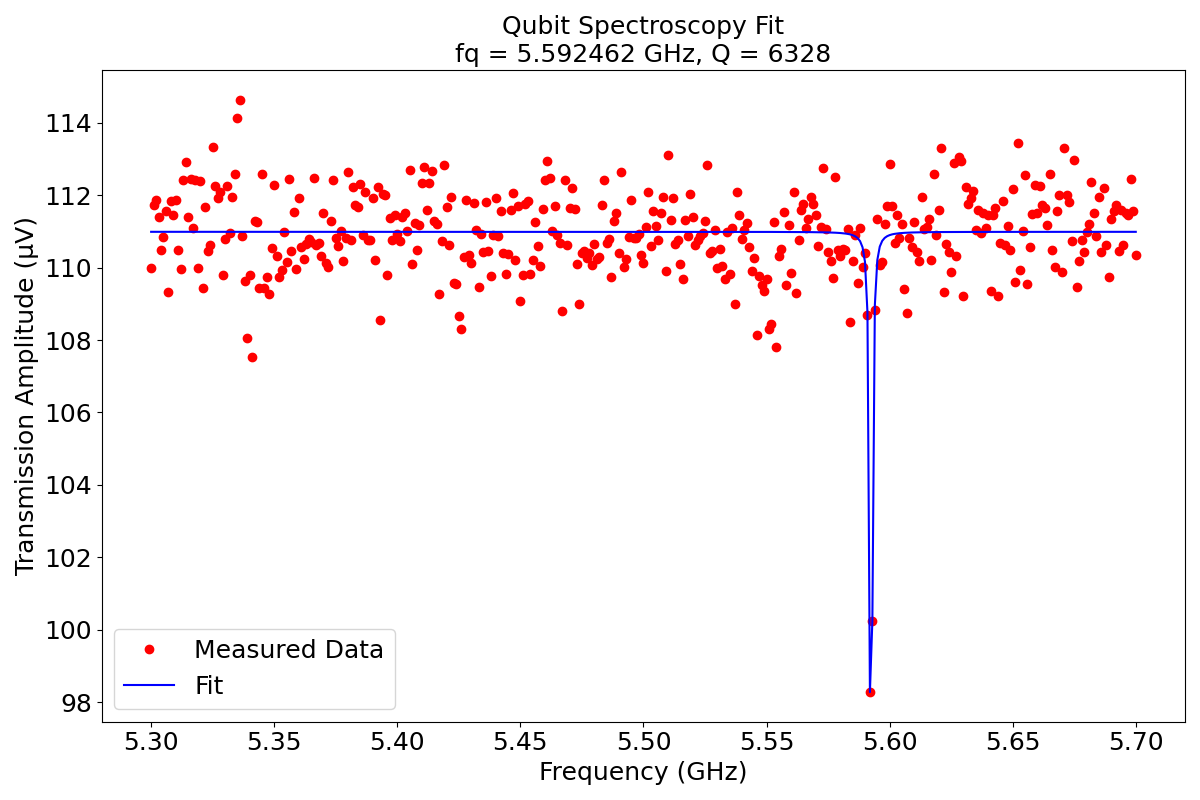

In [9]:
def plot_qubit_fit(f, y, popt, ax=None):
    f_in_ghz = f / 1e9
    
    y_fit = lorentzian(f, *popt)
    
    y_microvolts = y * 1e6
    y_fit_microvolts = y_fit * 1e6

    ax.plot(f_in_ghz, y_microvolts, 'ro', label='Measured Data')
    
    ax.plot(f_in_ghz, y_fit_microvolts, 'b-', label='Fit')
    
    ax.set_xlabel('Frequency (GHz)', fontsize=18)
    ax.set_ylabel('Transmission Amplitude (\u03BCV)', fontsize=18) 
    ax.set_title(f'Qubit Spectroscopy Fit\nfq = {popt[0]/1e9:.6f} GHz, Q = {popt[1]:.0f}', fontsize=18)
    ax.legend(fontsize=18)

    ax.tick_params(axis='both', labelsize=18)

fig, ax = plt.subplots(figsize=(12, 8))  
plot_qubit_fit(f, y, popt, ax=ax)
plt.tight_layout()
plt.savefig('qubit_spectroscopy_fit.png')

fq, Q, A, y0 = popt
print(f"Qubit Frequency (fq) = {fq/1e9:.6f} GHz")
print(f"Quality Factor (Q) = {Q:.0f}")
print(fq/Q)

# Rabi Oscillations

In [11]:
run_id = 4
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()
print(f"Measured parameters: {data.keys()}") 
data_amplitude = data["presto_in_ch1_amplitude"] #we care about amplitude
print(f"Independent parameters: {data_amplitude.dims}") #dimns of amplitude and what they are each, it was 2 types i.e. 0=freq,1=scale
measured_values = data_amplitude.data 
indep_param_1 = data_amplitude[data_amplitude.dims[1]].data 

x = indep_param_1
y = measured_values
y_mean = np.mean(y, axis=0)
print(y_mean.shape) 
print(x.shape)

Measured parameters: dict_keys(['presto_in_ch1_amplitude', 'presto_in_ch1_phase', 'presto_out_ch6_IF_freq'])
Independent parameters: ('presto_out_ch6_Probe_freq', 'qubit_pulse_length')
(101,)
(101,)


In [12]:
def target_function(t, Omega_R, T, Az, N, phi):
    return Az * np.exp(- t / T) * np.cos(Omega_R * t + phi) + N

initial_guess = [2.5e7, 500e-9, 4e-5, 7.5e-5, 0]

In [13]:
popt, pcov = curve_fit(target_function, x, y_mean, p0=initial_guess)

Omega_R_fit, T_fit, Az_fit, N_fit, Phi_fit = popt

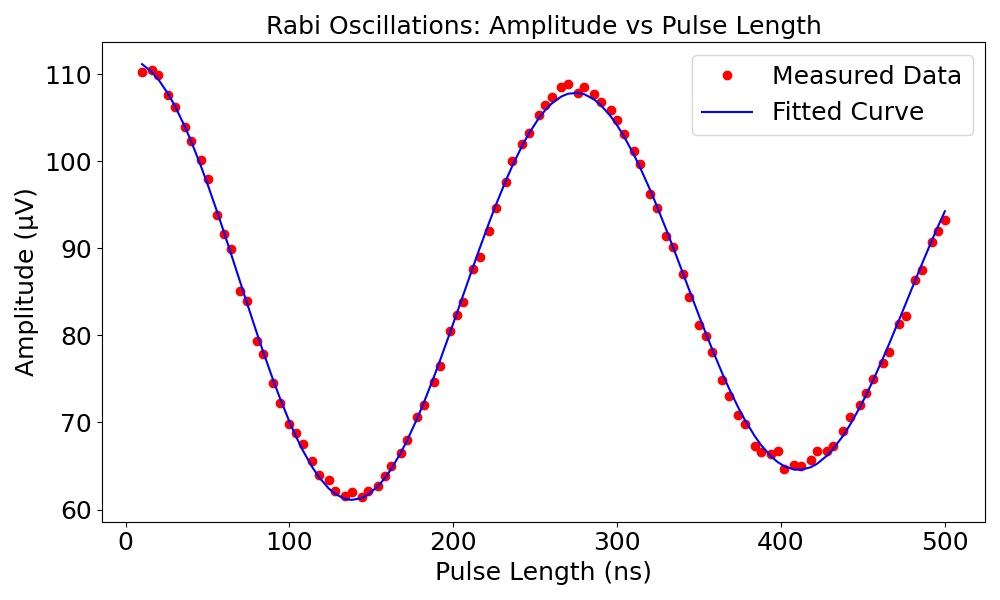

Omega_R_fit = 23060246.337804
Estimated pi-pulse length: 1.362341e-07 s


In [15]:
x_ns = x * 1e9 

y_microvolts = y_mean * 1e6

plt.figure(figsize=(10, 6))

plt.plot(x_ns, y_microvolts, 'ro', label='Measured Data')

plt.plot(x_ns, target_function(x, *popt) * 1e6, 'b-', label='Fitted Curve')

plt.title("Rabi Oscillations: Amplitude vs Pulse Length", fontsize=18)
plt.xlabel('Pulse Length (ns)', fontsize=18)
plt.ylabel('Amplitude (\u03BCV)', fontsize=18) 

plt.legend(fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()

plt.savefig('rabi_oscillations_corrected.png')

plt.show()


print(f"Omega_R_fit = {Omega_R_fit:.6f}")
pi_pulse_len = np.pi / Omega_R_fit   
print(f"Estimated pi-pulse length: {pi_pulse_len:.6e} s")

([<Axes: title={'center': 'Run #5, Experiment qubit_characterization_measurements (STF_MLA_V2)'}, xlabel='pulse length (ns)', ylabel='Amplitude'>,
  <Axes: title={'center': 'Run #5, Experiment qubit_characterization_measurements (STF_MLA_V2)'}, xlabel='pulse length (ns)', ylabel='Phase'>],
 [None, None])

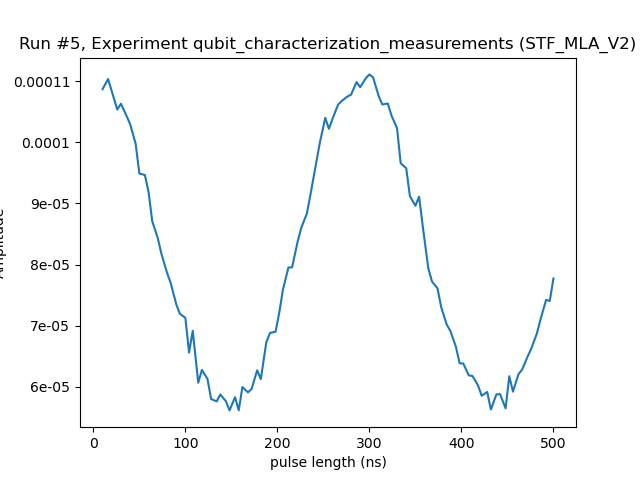

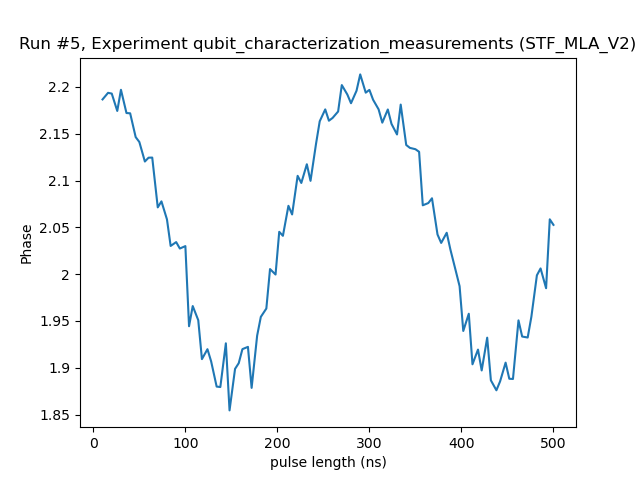

In [11]:
plot_by_id(5)

# Ramsey interferometry

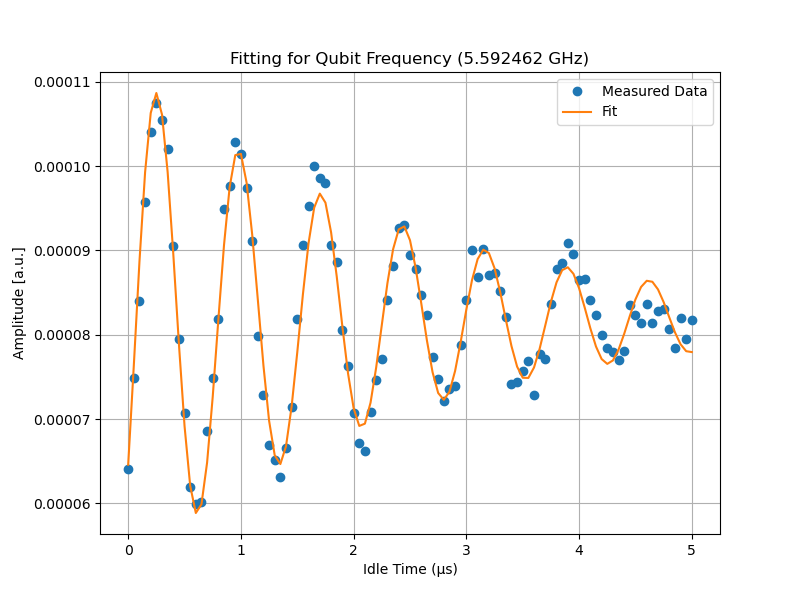

Average T2* Dephasing Time: 2.26 µs


In [6]:

run_id = 7
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()

data_amplitude = data["presto_in_ch1_amplitude"]
measured_values = data_amplitude.data  
probe_freqs = data_amplitude[data_amplitude.dims[0]].data  # Probe frequencies
idle_times = data_amplitude[data_amplitude.dims[1]].data  # Idle times

def ramsey_function(t, A, T2_star, fm, phi, C):
    return A * np.exp(-t / T2_star) * np.cos(fm * t + phi) + C

T2_star_values = []

for i, freq in enumerate(probe_freqs):
    y_values = measured_values[i, :]  
    
    
    initial_guess = [1e-4, 2.1e-6, 5e6, 0, np.mean(y_values)]  
    bounds = ([0, 0, 1e6, -np.pi, 0],  
              [np.inf, np.inf, 1e7, np.pi, np.inf])  
    
    try:
        params, covariance = curve_fit(ramsey_function, idle_times, y_values, p0=initial_guess, bounds=bounds)
        A_fit, T2_star_fit, fm_fit, phi_fit, C_fit = params
        
        T2_star_values.append(T2_star_fit)
        
        if i == 0:  
            fitted_curve = ramsey_function(idle_times, *params)
            plt.figure(figsize=(8, 6))
            plt.plot(idle_times * 1e6, y_values, 'o', label='Measured Data')
            plt.plot(idle_times * 1e6, fitted_curve, '-', label=f'Fit')
            plt.xlabel('Idle Time (µs)')
            plt.ylabel('Amplitude [a.u.]')
            plt.title(f'Fitting for Qubit Frequency (5.592462 GHz)')
            plt.legend()
            plt.grid(True)
            plt.show()

    except RuntimeError:
        print(f"Fit did not converge for frequency {freq}")

average_T2_star = np.mean(T2_star_values) if len(T2_star_values) > 0 else 0
print(f"Average T2* Dephasing Time: {average_T2_star * 1e6:.2f} µs")

# T1 measurement

In [12]:
run_id = 10
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()
print(f"Measured parameters: {data.keys()}")
data_amplitude = data["presto_in_ch1_amplitude"]
print(f"Independent parameters: {data_amplitude.dims}")   
measured_values = data_amplitude.data 
indep_param_2 = data_amplitude[data_amplitude.dims[1]].data

Measured parameters: dict_keys(['presto_in_ch1_amplitude', 'presto_in_ch1_phase'])
Independent parameters: ('Iteration', 'T1Protocol_idle_time')


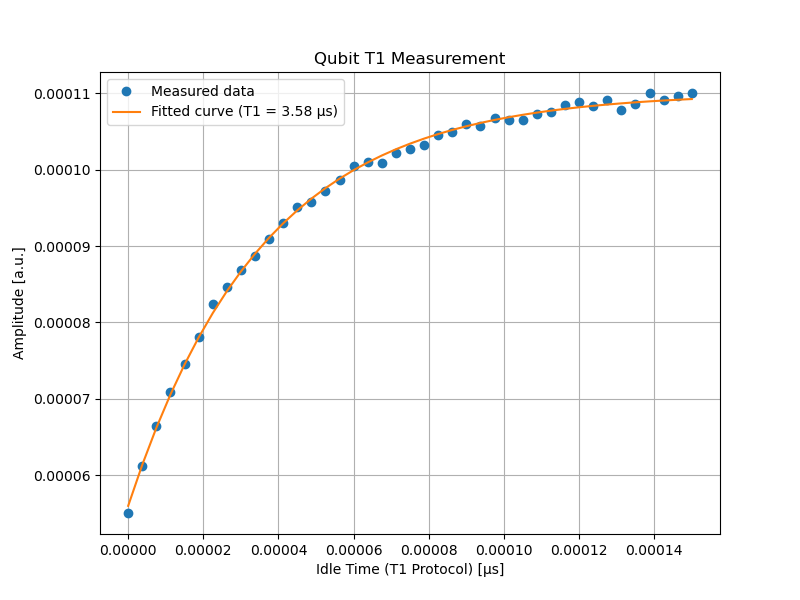

Fitted T1 Time: 3.58 µs


In [13]:
measured_averages = np.mean(measured_values, axis=0)

def exponential_decay(x, A, T2, C):
    return A * np.exp(-x / T2) + C

initial_guess = [1e-4, 6e-5, 6e-5]  
params, covariance = curve_fit(exponential_decay, indep_param_2, measured_averages, p0=initial_guess)

A_fit, T2_fit, C_fit = params

fitted_curve = exponential_decay(indep_param_2, A_fit, T2_fit, C_fit)

plt.figure(figsize=(8, 6))
plt.plot(indep_param_2, measured_averages, 'o', label='Measured data')
plt.plot(indep_param_2, fitted_curve, '-', label=f'Fitted curve (T1 = {T2_fit*1e5:.2f} µs)')

plt.xlabel('Idle Time (T1 Protocol) [µs]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Qubit T1 Measurement')
plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted T1 Time: {T2_fit*1e5:.2f} µs")

# T2 Echo measurement

In [20]:
run_id = 11
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()
print(f"Measured parameters: {data.keys()}")
data_amplitude = data["presto_in_ch1_amplitude"]
print(f"Independent parameters: {data_amplitude.dims}")   
measured_values = data_amplitude.data
indep_param_1 = data_amplitude[data_amplitude.dims[0]].data    
indep_param_2 = data_amplitude[data_amplitude.dims[1]].data

Measured parameters: dict_keys(['presto_in_ch1_amplitude', 'presto_in_ch1_phase'])
Independent parameters: ('Iteration', 'T2EchoProtocol_idle_time')


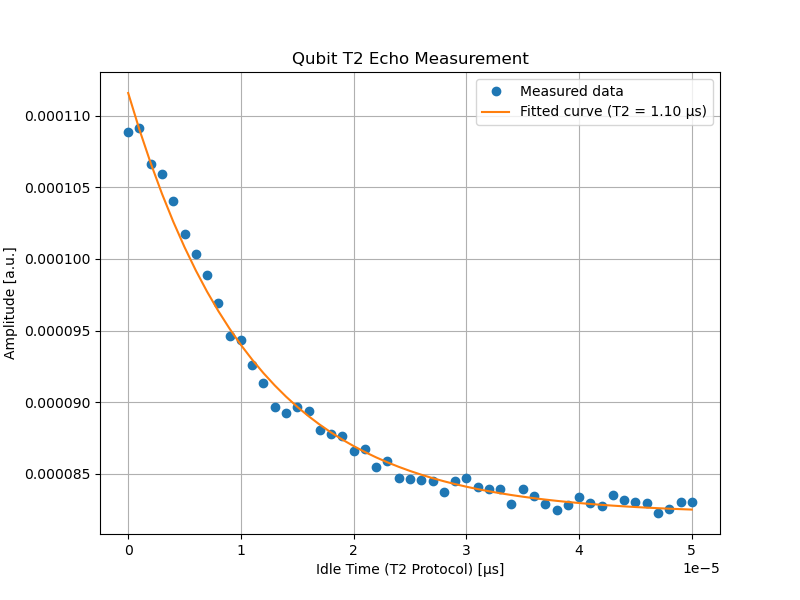

Fitted T2 Time: 1.10 µs


In [21]:
measured_averages = np.mean(measured_values, axis=0)

def exponential_decay(x, A, T2, C):
    return A * np.exp(-x / T2) + C

initial_guess = [1e-4, 1e-5, 8e-5]  
params, covariance = curve_fit(exponential_decay, indep_param_2, measured_averages, p0=initial_guess)


A_fit, T2_fit, C_fit = params


fitted_curve = exponential_decay(indep_param_2, A_fit, T2_fit, C_fit)


plt.figure(figsize=(8, 6))
plt.plot(indep_param_2, measured_averages, 'o', label='Measured data')
plt.plot(indep_param_2, fitted_curve, '-', label=f'Fitted curve (T2 = {T2_fit*1e5:.2f} µs)')

plt.xlabel('Idle Time (T2 Protocol) [µs]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Qubit T2 Echo Measurement')
plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted T2 Time: {T2_fit*1e5:.2f} µs")

([<Axes: title={'center': 'Run #2, Experiment qubit_characterization_measurements (STF_MLA_V2)'}, xlabel='Probe frequency (GHz)', ylabel='Scale'>,
  <Axes: title={'center': 'Run #2, Experiment qubit_characterization_measurements (STF_MLA_V2)'}, xlabel='Probe frequency (GHz)', ylabel='Scale'>],
  <matplotlib.colorbar.Colorbar at 0x7f580410f430>])

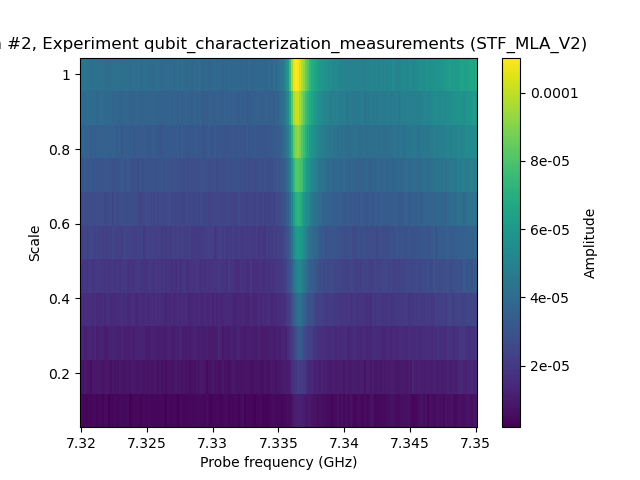

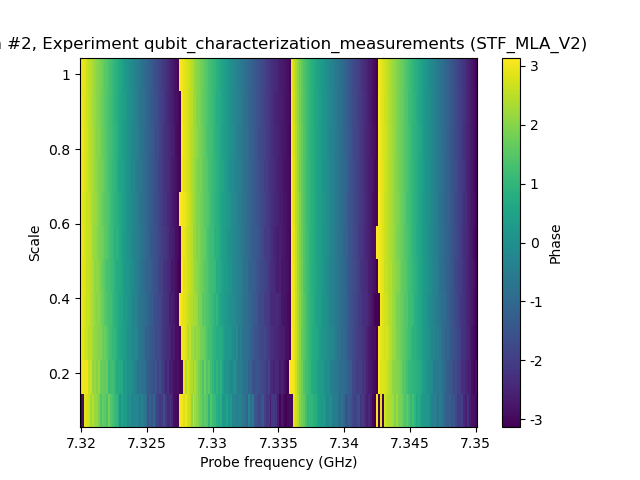

In [24]:
plot_by_id(2)

# CHI Measurement analysis

# Extra

Measured parameters: dict_keys(['presto_in_ch1_amplitude', 'presto_in_ch1_phase'])
Independent parameters: ('Iteration', 'T1Protocol_idle_time')


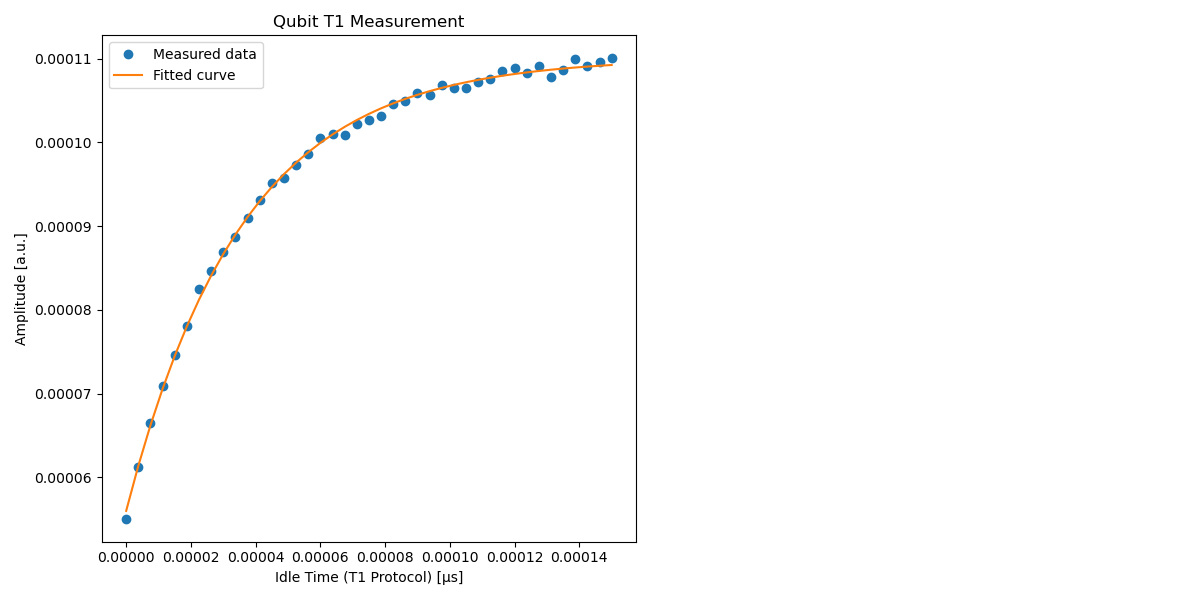

[3.712785487840303e-05, 3.725622383027424e-05, 4.0642707258849286e-05, 3.313480837218139e-05, 3.1440429643273294e-05]
Mean T1: 35.92 µs


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

run_id = 10
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()
print(f"Measured parameters: {data.keys()}")
data_amplitude = data["presto_in_ch1_amplitude"]
print(f"Independent parameters: {data_amplitude.dims}")   
measured_values = data_amplitude.data  
indep_param_2 = data_amplitude[data_amplitude.dims[1]].data  

measured_averages = np.mean(measured_values, axis=0)

def exponential_decay(x, A, T1, C):
    return A * np.exp(-x / T1) + C

T1_times = []
for i in range(measured_values.shape[0]):  
    y = measured_values[i, :]
    params, _ = curve_fit(exponential_decay, indep_param_2, y, p0=[1e-4, 6e-5, 6e-5])
    T1_times.append(params[1])  

A_fit, T1_fit, C_fit = curve_fit(exponential_decay, indep_param_2, measured_averages, p0=[1e-4, 6e-5, 6e-5])[0]
fitted_curve = exponential_decay(indep_param_2, A_fit, T1_fit, C_fit)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  
plt.plot(indep_param_2, measured_averages, 'o', label='Measured data')
plt.plot(indep_param_2, fitted_curve, '-', label=f'Fitted curve')
plt.xlabel('Idle Time (T1 Protocol) [µs]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Qubit T1 Measurement')
plt.legend()



plt.tight_layout()
plt.show()

mean_T1 = np.mean(T1_times)
std_T1 = np.std(T1_times)
print(T1_times)
print(f"Mean T1: {mean_T1*1e6:.2f} µs")

Measured parameters: dict_keys(['presto_in_ch1_amplitude', 'presto_in_ch1_phase'])
Independent parameters: ('Iteration', 'T2EchoProtocol_idle_time')


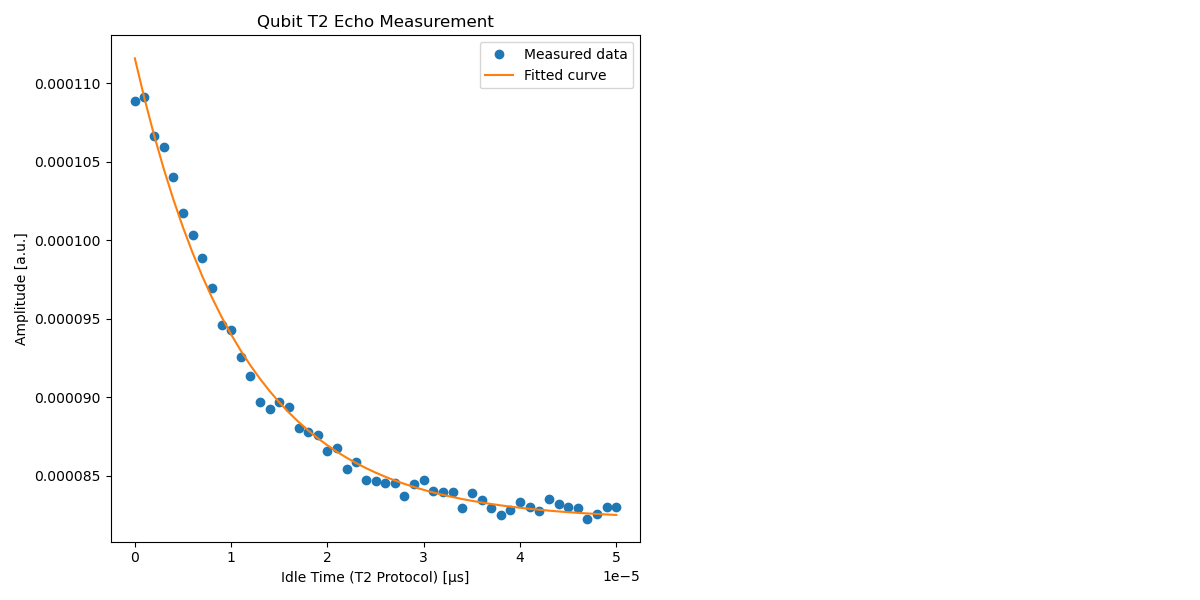

[1.017319720018743e-05, 1.0874822867695125e-05, 1.0508110511763003e-05, 1.1620750235789485e-05, 1.1694567821537672e-05]
Mean T2: 10.97 µs


In [11]:
run_id = 11
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()
print(f"Measured parameters: {data.keys()}")
data_amplitude = data["presto_in_ch1_amplitude"]
print(f"Independent parameters: {data_amplitude.dims}")   
measured_values = data_amplitude.data  
indep_param_2 = data_amplitude[data_amplitude.dims[1]].data  

measured_averages = np.mean(measured_values, axis=0)

def exponential_decay(x, A, T2, C):
    return A * np.exp(-x / T2) + C

T2_times = []
for i in range(measured_values.shape[0]):  
    y = measured_values[i, :]
    params, _ = curve_fit(exponential_decay, indep_param_2, y, p0=[1e-4, 1e-5, 8e-5])
    T2_times.append(params[1])  

A_fit, T2_fit, C_fit = curve_fit(exponential_decay, indep_param_2, measured_averages, p0=[1e-4, 1e-5, 8e-5])[0]
fitted_curve = exponential_decay(indep_param_2, A_fit, T2_fit, C_fit)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  
plt.plot(indep_param_2, measured_averages, 'o', label='Measured data')
plt.plot(indep_param_2, fitted_curve, '-', label=f'Fitted curve')
plt.xlabel('Idle Time (T2 Protocol) [µs]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Qubit T2 Echo Measurement')
plt.legend()



plt.tight_layout()
plt.show()

mean_T2 = np.mean(T2_times)
std_T2 = np.std(T2_times)
print(T2_times)
print(f"Mean T2: {mean_T2*1e6:.2f} µs")



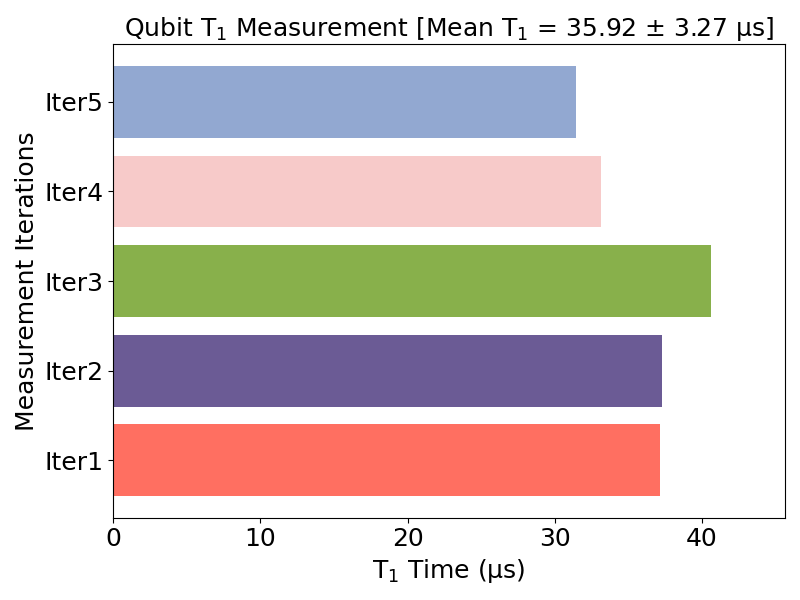

x


In [27]:
run_id = 10
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()
data_amplitude = data["presto_in_ch1_amplitude"]

measured_values = data_amplitude.data
indep_param_2 = data_amplitude[data_amplitude.dims[1]].data  

idle_time_us = indep_param_2 * 1e6  

measured_values_uv = measured_values * 1e6  

def exponential_decay(x, A, T1, C):
    return A * np.exp(-x / T1) + C

T1_values = []
for i in range(measured_values.shape[0]):
    y_data = measured_values_uv[i, :]  
    initial_guess = [np.max(y_data), 30, np.min(y_data)]  
    params, _ = curve_fit(exponential_decay, idle_time_us, y_data, p0=initial_guess)
    
    A_fit, T1_fit, C_fit = params
    T1_values.append(T1_fit)

T1_mean = np.mean(T1_values)
T1_std = np.std(T1_values)

iterations = [f'Iter{i+1}' for i in range(len(T1_values))]
bar_colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1']  

plt.figure(figsize=(8, 6))
plt.barh(iterations, T1_values, color=bar_colors)

plt.title(f"Qubit T$_1$ Measurement [Mean T$_1$ = {T1_mean:.2f} ± {T1_std:.2f} µs]", fontsize=18)
plt.xlabel('T$_1$ Time (µs)', fontsize=18)
plt.ylabel('Measurement Iterations', fontsize=18)
plt.xlim([0, np.max(T1_values) + 5])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()

print(f"x")


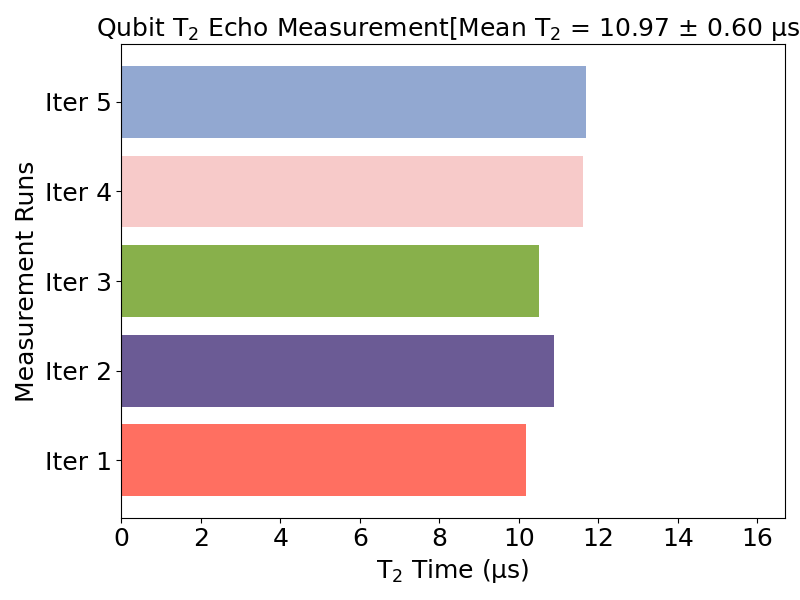

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

run_id = 11
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()
data_amplitude = data["presto_in_ch1_amplitude"]

measured_values = data_amplitude.data
indep_param_2 = data_amplitude[data_amplitude.dims[1]].data 

idle_time_us = indep_param_2 * 1e6  
measured_values_uv = measured_values * 1e6  
def exponential_decay(x, A, T2, C):
    return A * np.exp(-x / T2) + C

T2_times = []
for i in range(measured_values.shape[0]):  
    y_data = measured_values_uv[i, :]  
    initial_guess = [np.max(y_data), 30, np.min(y_data)]  
    params, _ = curve_fit(exponential_decay, idle_time_us, y_data, p0=initial_guess)
    
    A_fit, T2_fit, C_fit = params
    T2_times.append(T2_fit)

mean_T2 = np.mean(T2_times)
std_T2 = np.std(T2_times)

iterations = [f'Iter {i+1}' for i in range(len(T2_times))]
bar_colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1']  

plt.figure(figsize=(8, 6))
plt.barh(iterations, T2_times, color=bar_colors)

plt.title(f"Qubit T$_2$ Echo Measurement[Mean T$_2$ = {mean_T2:.2f} ± {std_T2:.2f} µs] ", fontsize=18)
plt.xlabel('T$_2$ Time (µs)', fontsize=18)
plt.ylabel('Measurement Runs', fontsize=18)
plt.xlim([0, np.max(T2_times) + 5])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()

Mean T2* = 2.26 µs ± 1.13 µs


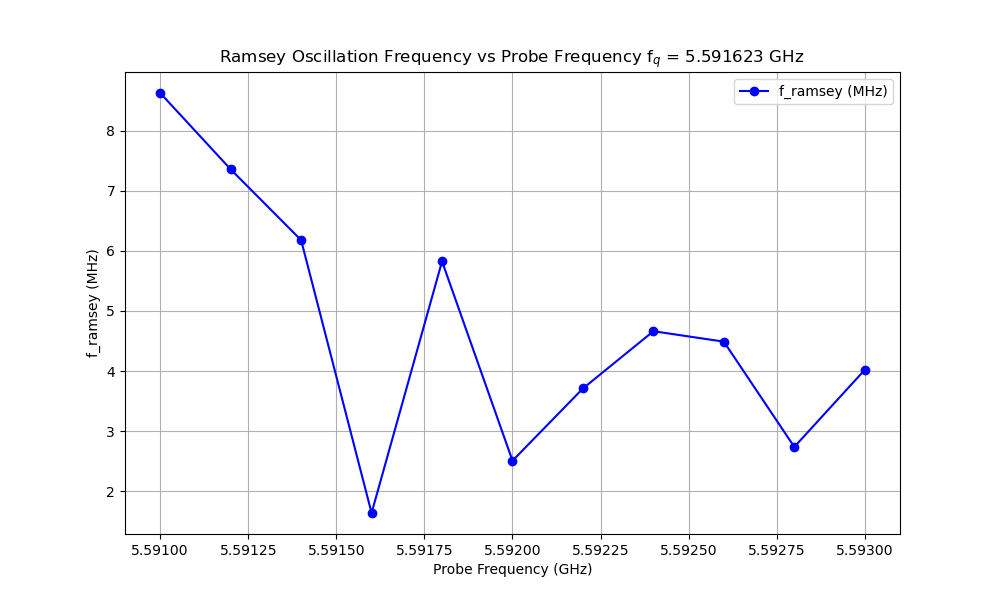

In [40]:
run_id = 7
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()

data_amplitude = data["presto_in_ch1_amplitude"]

measured_values = data_amplitude.data 
probe_freqs = data_amplitude[data_amplitude.dims[0]].data 
idle_times = data_amplitude[data_amplitude.dims[1]].data  

def ramsey_function(t, A, T2_star, fm, phi, C):
    return A * np.exp(-t / T2_star) * np.cos(fm * t + phi) + C

f_ramsey_values = []
T2_star_values = []

for i, freq in enumerate(probe_freqs):
    y_values = measured_values[i, :]  
    
    initial_guess = [1e-4, 2.1e-6, 5e6, 0, np.mean(y_values)]  
    bounds = ([0, 0, 1e6, -np.pi, 0],  
              [np.inf, np.inf, 1e7, np.pi, np.inf])  
    
    try:
        params, covariance = curve_fit(ramsey_function, idle_times, y_values, p0=initial_guess, bounds=bounds)
        A_fit, T2_star_fit, fm_fit, phi_fit, C_fit = params
        
        T2_star_values.append(T2_star_fit)
        f_ramsey_values.append(fm_fit)
        
        if i == 100:  
            fitted_curve = ramsey_function(idle_times, *params)
            plt.figure(figsize=(8, 6))
            plt.plot(idle_times * 1e6, y_values, 'o', label='Measured Data')
            plt.plot(idle_times * 1e6, fitted_curve, '-', label=f'Fit')
            plt.xlabel('Idle Time (µs)')
            plt.ylabel('Amplitude [a.u.]')
            plt.title(f'Fitting for Qubit Frequency (Probe {freq/1e9:.6f} GHz)')
            plt.legend()
            plt.grid(True)
            plt.show()

    except RuntimeError:
        print(f"Fit did not converge for frequency {freq}")

f_ramsey_values = np.array(f_ramsey_values) / 1e6


def v_shape_fit(f, fq, a, b):
    return np.abs(a * (f - fq)**2) + b  

initial_guess_vshape = [probe_freqs[np.argmin(f_ramsey_values)], 1e6, np.min(f_ramsey_values)]
params_vshape, _ = curve_fit(v_shape_fit, probe_freqs, f_ramsey_values * 1e6, p0=initial_guess_vshape)

fq_fit, a_fit, b_fit = params_vshape

filtered_T2_star_values = [T2 for i, T2 in enumerate(T2_star_values) if f_ramsey_values[i] > 0.5]  

if len(filtered_T2_star_values) > 0:
    mean_T2_star = np.mean(filtered_T2_star_values)
    std_T2_star = np.std(filtered_T2_star_values)
    print(f"Mean T2* = {mean_T2_star * 1e6:.2f} µs ± {std_T2_star * 1e6:.2f} µs")
else:
    print("No valid data for T2* calculation.")
    
plt.figure(figsize=(10, 6))
plt.plot(probe_freqs / 1e9, f_ramsey_values, 'bo-', label='f_ramsey (MHz)')
plt.xlabel('Probe Frequency (GHz)')
plt.ylabel('f_ramsey (MHz)')
plt.title(f"Ramsey Oscillation Frequency vs Probe Frequency f$_q$ = {fq_fit / 1e9:.6f} GHz ")
plt.grid(True)
plt.legend()
plt.show()


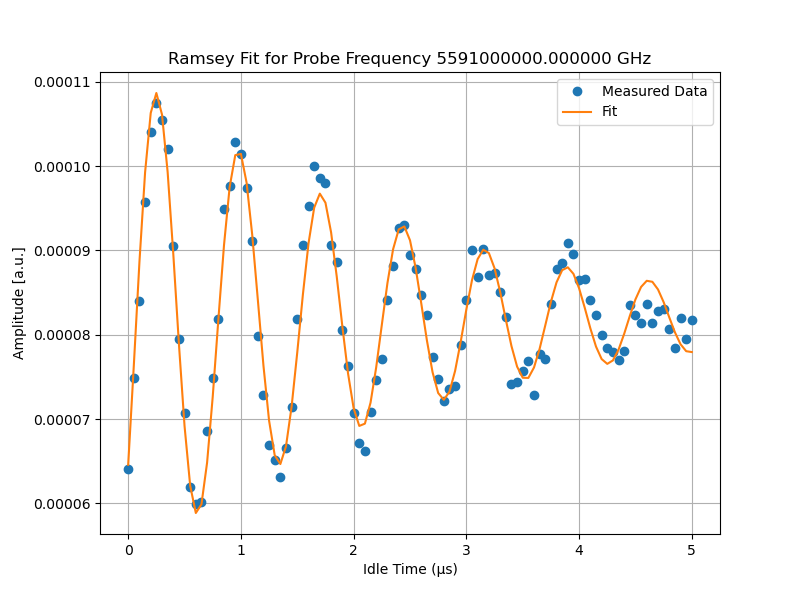

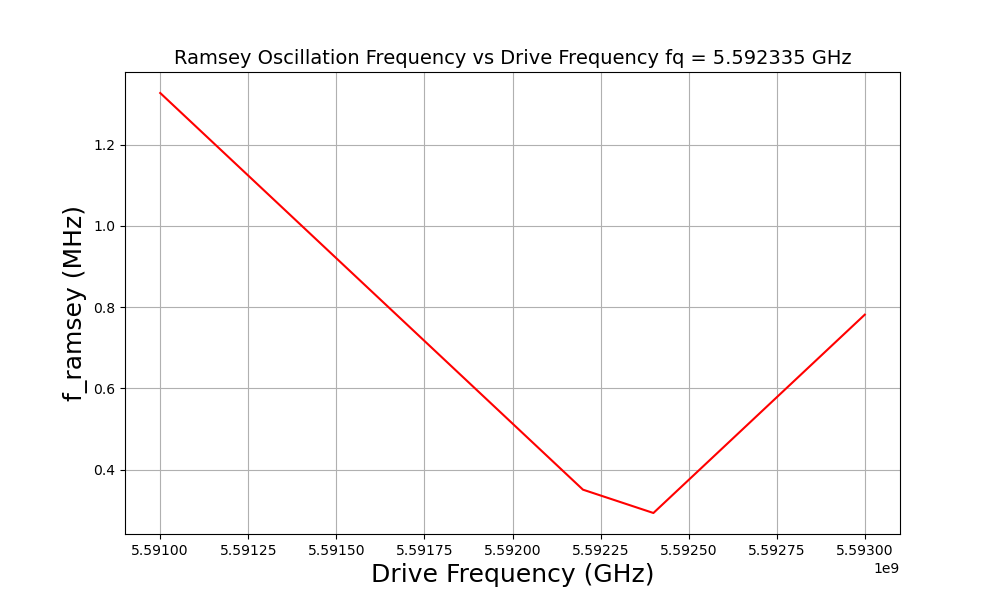

Extracted Qubit Frequency from V-shaped fit: fq = 5592335303.587000 GHz
Mean T2* = 1.82 µs ± 1.38 µs


In [55]:
def ramsey_function(t, A, T2_star, fm, phi, C):
    return A * np.exp(-t / T2_star) * np.cos(fm * t + phi) + C

def v_shape_function(probe_freqs, fq, a, f_min):
    return a * np.abs(probe_freqs - fq) + f_min

run_id = 7
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()

data_amplitude = data["presto_in_ch1_amplitude"]

measured_values = data_amplitude.data  
probe_freqs = data_amplitude[data_amplitude.dims[0]].data  
idle_times = data_amplitude[data_amplitude.dims[1]].data  

f_ramsey_values = []
T2_star_values = []

for i, freq in enumerate(probe_freqs):
    y_values = measured_values[i, :]  
    
    initial_guess = [1e-4, 1.2e-6, 4e6, 0, np.mean(y_values)]  
    bounds = ([0, 0, 1e6, -np.pi, 0],  
              [np.inf, np.inf, 1e7, np.pi, np.inf])  
    
    try:
        params, covariance = curve_fit(ramsey_function, idle_times, y_values, p0=initial_guess, bounds=bounds)
        A_fit, T2_star_fit, fm_fit, phi_fit, C_fit = params
        
        f_ramsey_values.append(fm_fit / (2 * np.pi * 1e6))  
        T2_star_values.append(T2_star_fit * 1e6)  
        
        if i == 0:
            fitted_curve = ramsey_function(idle_times, *params)
            plt.figure(figsize=(8, 6))
            plt.plot(idle_times * 1e6, y_values, 'o', label='Measured Data')
            plt.plot(idle_times * 1e6, fitted_curve, '-', label=f'Fit')
            plt.xlabel('Idle Time (µs)')
            plt.ylabel('Amplitude [a.u.]')
            plt.title(f'Ramsey Fit for Probe Frequency {freq:.6f} GHz')
            plt.legend()
            plt.grid(True)
            plt.show()
    
    except RuntimeError:
        print(f"Fit did not converge for frequency {freq}")

initial_guess_vshape = [probe_freqs[np.argmin(f_ramsey_values)], 1e6, np.min(f_ramsey_values)]
params_vshape, _ = curve_fit(v_shape_function, probe_freqs, f_ramsey_values, p0=initial_guess_vshape)

fq_fit, a_fit, f_min_fit = params_vshape

plt.figure(figsize=(10, 6))
plt.plot(probe_freqs, v_shape_function(probe_freqs, fq_fit, a_fit, f_min_fit), 'r-')
plt.xlabel('Drive Frequency (GHz)', fontsize=18)
plt.ylabel('f_ramsey (MHz)', fontsize=18)
plt.title(f'Ramsey Oscillation Frequency vs Drive Frequency fq = {fq_fit/1e9:.6f} GHz', fontsize=14)
plt.grid(True)
plt.show()

mean_T2_star = np.mean(T2_star_values)
std_T2_star = np.std(T2_star_values)

print(f"Extracted Qubit Frequency from V-shaped fit: fq = {fq_fit:.6f} GHz")
print(f"Mean T2* = {mean_T2_star:.2f} µs ± {std_T2_star:.2f} µs")


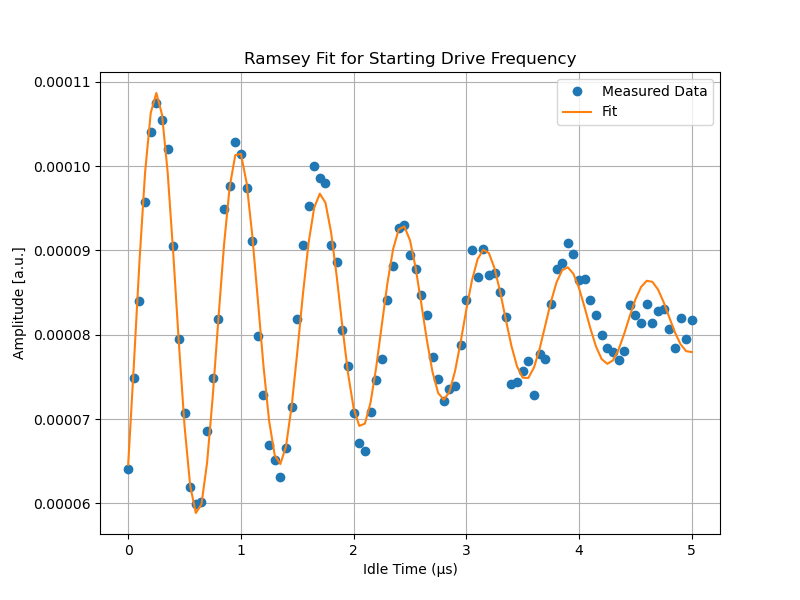

Mean T2* Dephasing Time: 1.87 µs ± 1.01 µs
Selected Frequencies: [5591000000.0, 5591200000.0, 5591400000.0, 5591600000.0, 5591800000.0, 5592000000.0, 5592200000.0, 5592600000.0, 5592800000.0, 5593000000.0]


In [86]:
def ramsey_function(t, A, T2_star, fm, phi, C):
    return A * np.exp(-t / T2_star) * np.cos(fm * t + phi) + C

run_id = 7
data = qc.load_by_id(run_id).to_xarray_dataarray_dict()
data_amplitude = data["presto_in_ch1_amplitude"]
measured_values = data_amplitude.data
probe_freqs = data_amplitude[data_amplitude.dims[0]].data
idle_times = data_amplitude[data_amplitude.dims[1]].data

oscillation_threshold = 0.00001  
selected_frequencies = []
T2_star_values = []

for i, freq in enumerate(probe_freqs):
    y_values = measured_values[i, :]
    
    if np.std(y_values) > oscillation_threshold:
        selected_frequencies.append(freq)
        
        initial_guess = [np.max(y_values), 1e-6, 5e6, 0, np.mean(y_values)]
        bounds = ([0, 0, 1e6, -np.pi, 0], [np.inf, np.inf, 1e7, np.pi, np.inf])

        try:
            params, _ = curve_fit(ramsey_function, idle_times, y_values, p0=initial_guess, bounds=bounds)
            A_fit, T2_star_fit, fm_fit, phi_fit, C_fit = params
            T2_star_values.append(T2_star_fit)
            
            if len(selected_frequencies) == 1:
                fitted_curve = ramsey_function(idle_times, *params)
                plt.figure(figsize=(8, 6))
                plt.plot(idle_times * 1e6, y_values, 'o', label=f'Measured Data')
                plt.plot(idle_times * 1e6, fitted_curve, '-', label=f'Fit')
                plt.xlabel('Idle Time (µs)')
                plt.ylabel('Amplitude [a.u.]')
                plt.title(f'Ramsey Fit for Starting Drive Frequency')
                plt.legend()
                plt.grid(True)
                plt.show()
                
        except RuntimeError:
            print(f"Fit did not converge for frequency {freq}")
            T2_star_values.append(np.nan)  

if len(T2_star_values) > 0:
    mean_T2_star = np.mean(T2_star_values)
    std_T2_star = np.std(T2_star_values)
else:
    mean_T2_star = std_T2_star = 0

print(f"Mean T2* Dephasing Time: {mean_T2_star * 1e6:.2f} µs ± {std_T2_star * 1e6:.2f} µs")
print(f"Selected Frequencies: {selected_frequencies}")


In [70]:
print(T2_star_values)

[2.4759909407157643e-06, 2.5977549074882107e-06, 2.603197930317959e-06, 3.025649681971903e-07, 4.4278998076981196e-07, 1.9532141551065893e-06, 1.8767000693465901e-06, 2.9764874772090714e-06, 2.9741742938830264e-06, 5.0876244652812e-07]


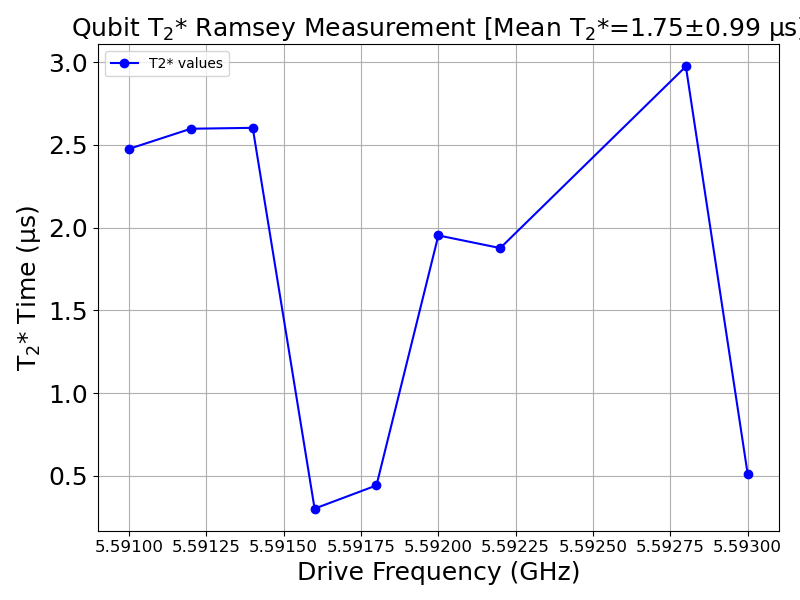

In [85]:
selected_frequencies = [5591000000.0, 5591200000.0, 5591400000.0, 5591600000.0, 5591800000.0, 
                        5592000000.0, 5592200000.0, 5592800000.0, 5593000000.0]
T2_star_values = [2.4759909407157643e-06, 2.5977549074882107e-06, 2.603197930317959e-06, 
                  3.025649681971903e-07, 4.4278998076981196e-07, 1.9532141551065893e-06, 
                  1.8767000693465901e-06, 2.9741742938830264e-06, 
                  5.0876244652812e-07]

selected_frequencies_ghz = [freq / 1e9 for freq in selected_frequencies]

T2_star_values_us = [val * 1e6 for val in T2_star_values]

mean_T2_star = np.mean(T2_star_values_us)
std_T2_star = np.std(T2_star_values_us)

plt.figure(figsize=(8, 6))
plt.plot(selected_frequencies_ghz, T2_star_values_us, 'o-', color='blue', label='T2* values')

plt.title(f"Qubit T$_2$* Ramsey Measurement [Mean T$_2$*={mean_T2_star:.2f}±{std_T2_star:.2f} µs]", fontsize=18)
plt.xlabel('Drive Frequency (GHz)', fontsize=18)
plt.ylabel('T$_2$* Time (µs)', fontsize=18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=18)

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
